In [ ]:
!pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 31.2 MB/s eta 0:00:00


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 6.68     |
| time/              |          |
|    fps             | 894      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | 6           |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010370929 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.0102     |
|    learning

<ipython-input-92-08829848f3d1>:266: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actions.append(int(action))


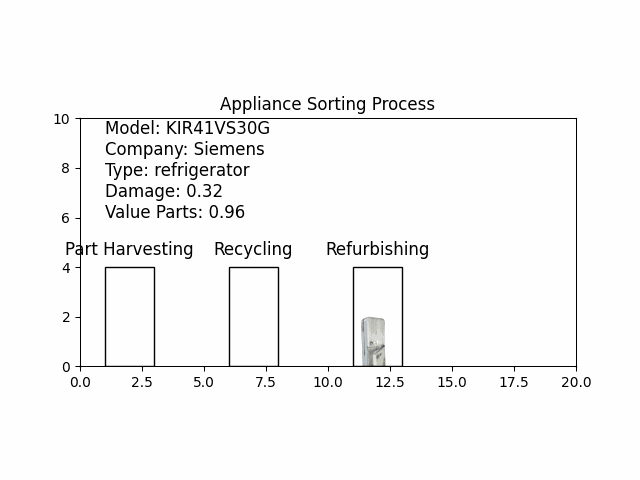

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


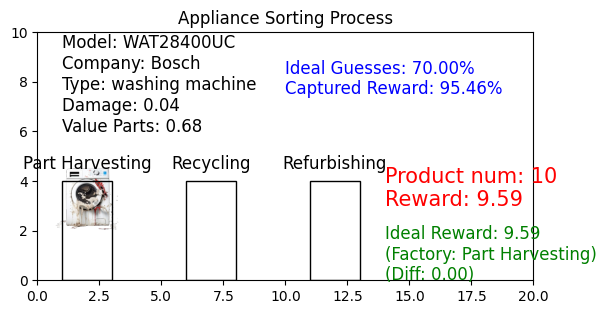

In [ ]:
import random
import numpy as np
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from gymnasium import spaces
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython import display
import time
from stable_baselines3.common.utils import set_random_seed
from PIL import Image
import requests
from io import BytesIO


# SEED_CHOICE = 42
# SEED_CHOICE = 1
SEED_CHOICE = 2

APPLIANCE_COUNT = 20000
TRAINING_LENGTH = 10000
RESIZE_IMAGES_TO = (300, 300)
FACTORY_A_NAME = "Part Harvesting"
FACTORY_B_NAME = "Recycling"
FACTORY_C_NAME = "Refurbishing"
CAPTURED_REWARD_TEXT = "Captured Reward"
IMAGE_SCALE_FACTOR = 1.5  # Global value to scale the visual size of the images in the animation
np.random.seed(SEED_CHOICE)
set_random_seed(SEED_CHOICE)

# Define the Appliance class
class Appliance:
    def __init__(self, model_name, company_name, damage, value_parts, appliance_type):
        self.model_name = model_name
        self.company_name = company_name
        self.damage = damage  # Float between 0 and 1
        self.value_parts = value_parts  # Float between 0 and 1
        self.appliance_type = appliance_type

# Define the Factory class with a method to calculate rewards
class Factory:
    def __init__(self, name, location):
        self.name = name
        self.location = location

    def evaluate_appliance(self, appliance):
        # Calculate reward or loss for an appliance based on factory location
        if self.location == FACTORY_A_NAME:
            base_value = 6 * (1 - appliance.damage) + 4 * appliance.value_parts
        elif self.location == FACTORY_B_NAME:
            base_value = 5 * (1 - appliance.damage) + 5 * appliance.value_parts
        elif self.location == FACTORY_C_NAME:
            base_value = 4 * (1 - appliance.damage) + 6 * appliance.value_parts
        if self.location == FACTORY_A_NAME:
            if appliance.model_name == "WAT28400UC":
                reward = 9 + np.random.uniform(0, 1)  # Ensure reward is between 9 and 10
            else:
                reward = base_value + np.random.normal(0, 3)  # Normal distribution with mean 0, std 3
        elif self.location == FACTORY_B_NAME:
            if appliance.model_name == "KGV36VW32G":
                reward = 9 + np.random.uniform(0, 1)  # Ensure reward is between 9 and 10
            else:
                reward = base_value + np.random.uniform(-5, 5)  # Uniform distribution between -5 and 5
        elif self.location == FACTORY_C_NAME:
            if appliance.model_name == "WT45N202GB":
                reward = 9 + np.random.uniform(0, 1)  # Ensure reward is between 9 and 10
            else:
                reward = base_value + np.random.beta(2, 2) * 10 - 5  # Beta distribution scaled to range -5 to 5
        else:
            reward = base_value + random.uniform(-5, 5)
        return max(-10, min(10, reward))  # Restrict to range -10 to 10

# Create some mock data with different distributions for different models
washing_machine_models = [
    "WAT28400UC", "WTG86400UC", "WAX32M41GB", "WAU28PH9GB", "WAN28281GB", "WAT28371GB"
]
refrigerator_models = [
    "KGV36VW32G", "KGN34NWEAG", "KIR41VS30G", "KGN33NW3AG", "KGN39VWEAG", "KIR18V60"
]
laundry_machine_models = [
    "WT45N202GB", "WT47RT90GB", "WT45H200GB", "WT46G491GB", "WT47W580GB", "WT47XMH9GB"
]
company_names = ["Bosch", "Siemens"]
appliance_types = ["washing machine", "refrigerator", "dishwasher"]

appliances = []

for _ in range(APPLIANCE_COUNT):
    appliance_type = random.choice(appliance_types)
    if appliance_type == "washing machine":
        model_name = random.choice(washing_machine_models)
    elif appliance_type == "refrigerator":
        model_name = random.choice(refrigerator_models)
    else:
        model_name = random.choice(laundry_machine_models)

    company_name = random.choice(company_names)

    # Use different distributions for different models
    if model_name in washing_machine_models:
        damage = np.clip(np.random.beta(2, 5), 0, 1)  # More likely to have lower damage
        value_parts = np.clip(np.random.normal(0.7, 0.1), 0, 1)  # Centered around 0.7
    elif model_name in refrigerator_models:
        damage = np.clip(np.random.uniform(0, 1), 0, 1)  # Uniform distribution
        value_parts = np.clip(np.random.beta(5, 2), 0, 1)  # More likely to have higher value
    else:
        damage = np.clip(np.random.normal(0.5, 0.2), 0, 1)  # Centered around 0.5
        value_parts = np.clip(np.random.uniform(0, 1), 0, 1)  # Uniform distribution

    appliances.append(Appliance(model_name, company_name, damage, value_parts, appliance_type))

# Create factories
factory_nurnberg = Factory(FACTORY_A_NAME, FACTORY_A_NAME)
factory_munich = Factory(FACTORY_B_NAME, FACTORY_B_NAME)
factory_frankfurt = Factory(FACTORY_C_NAME, FACTORY_C_NAME)

# Define a custom Gym environment for the appliance sorting problem
class ApplianceSortingEnv(gym.Env):
    def __init__(self):
        super(ApplianceSortingEnv, self).__init__()
        self.factories = [factory_nurnberg, factory_munich, factory_frankfurt]
        self.appliances = appliances
        self.current_appliance = None
        self.action_space = spaces.Discrete(len(self.factories))  # Three factories to choose from
        self.observation_space = spaces.Dict({
            "damage": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            "value_parts": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            "model_name": spaces.Discrete(len(washing_machine_models) + len(refrigerator_models) + len(laundry_machine_models)),
            "company_name": spaces.Discrete(len(company_names)),
            "appliance_type": spaces.Discrete(len(appliance_types))
        })

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_appliance = random.choice(self.appliances)
        model_index = (washing_machine_models + refrigerator_models + laundry_machine_models).index(self.current_appliance.model_name)
        company_index = company_names.index(self.current_appliance.company_name)
        appliance_type_index = appliance_types.index(self.current_appliance.appliance_type)
        observation = {
            "damage": np.array([self.current_appliance.damage], dtype=np.float32),
            "value_parts": np.array([self.current_appliance.value_parts], dtype=np.float32),
            "model_name": model_index,
            "company_name": company_index,
            "appliance_type": appliance_type_index
        }
        return observation, {}

    def step(self, action):
        selected_factory = self.factories[action]
        reward = selected_factory.evaluate_appliance(self.current_appliance)
        done = True  # Each episode consists of selecting a factory for one appliance
        info = {}
        model_index = (washing_machine_models + refrigerator_models + laundry_machine_models).index(self.current_appliance.model_name)
        company_index = company_names.index(self.current_appliance.company_name)
        appliance_type_index = appliance_types.index(self.current_appliance.appliance_type)
        observation = {
            "damage": np.array([self.current_appliance.damage], dtype=np.float32),
            "value_parts": np.array([self.current_appliance.value_parts], dtype=np.float32),
            "model_name": model_index,
            "company_name": company_index,
            "appliance_type": appliance_type_index
        }
        return observation, reward, done, False, info

    def render(self, mode='human'):
        print(f"Appliance: {self.current_appliance.model_name} ({self.current_appliance.company_name}) - Type: {self.current_appliance.appliance_type}")
        print(f"  Damage: {self.current_appliance.damage}, Value parts: {self.current_appliance.value_parts}")

# Create the environment
env = ApplianceSortingEnv()
env = Monitor(env)  # Wrap the env with a Monitor wrapper
env = DummyVecEnv([lambda: env])  # Wrap the env in a DummyVecEnv

# Set a random seed for reproducibility
env.seed(SEED_CHOICE)

# Create the PPO agent
model = PPO('MultiInputPolicy', env, verbose=1)

# Train the agent
model.learn(total_timesteps=TRAINING_LENGTH)

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100, render=False)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

# Helper function to determine ideal action and reward
def show_ideal_reward(appliance, random_state, np_random_state):
    best_action = None
    best_reward = float('-inf')

    # Evaluate all factories and find the best one
    for factory_idx, factory in enumerate(env.envs[0].env.factories):
        # Restore the previous random states
        random.setstate(random_state)
        np.random.set_state(np_random_state)
        reward = factory.evaluate_appliance(appliance)
        if reward > best_reward:
            best_reward = reward
            best_action = factory_idx

    return best_action, best_reward

# Visualization function to save animation
def visualize_sorting_process():
    fig, ax = plt.subplots()
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 10)
    ax.set_title("Appliance Sorting Process")
    conveyor_belts = {
        0: (2, FACTORY_A_NAME),
        1: (7, FACTORY_B_NAME),
        2: (12, FACTORY_C_NAME)
    }
    for key, (x, name) in conveyor_belts.items():
        ax.text(x, 4.5, name, ha='center', fontsize=12, color='black')
        ax.add_patch(patches.Rectangle((x - 1, 0), 2, 4, fill=False))

    # Create a circle to represent the appliance
    circle_patch = patches.Circle((0, 0.5), 0.2, color='blue', visible=False)
    ax.add_patch(circle_patch)

    # Load the appliance images from the URL
    response_washing_machine = requests.get("https://www.batikanor.com/images/other/broken_washing_machine.png")
    washing_machine_img = Image.open(BytesIO(response_washing_machine.content))
    washing_machine_img = washing_machine_img.resize(RESIZE_IMAGES_TO)  # Resize the image as needed
    img_washing_machine_patch = ax.imshow(washing_machine_img, extent=(0, 0, 0.5, 0.5), visible=False)

    response_refrigerator = requests.get("https://www.batikanor.com/images/other/broken_refrigerator.png")
    refrigerator_img = Image.open(BytesIO(response_refrigerator.content))
    refrigerator_img = refrigerator_img.resize(RESIZE_IMAGES_TO)
    img_refrigerator_patch = ax.imshow(refrigerator_img, extent=(0, 0, 0.5, 0.5), visible=False)

    response_dishwasher = requests.get("https://www.batikanor.com/images/other/broken_dishwasher.png")
    dishwasher_img = Image.open(BytesIO(response_dishwasher.content))
    dishwasher_img = dishwasher_img.resize(RESIZE_IMAGES_TO)
    img_dishwasher_patch = ax.imshow(dishwasher_img, extent=(0, 0, 0.5, 0.5), visible=False)

    reward_text = ax.text(0.5, 0.2, '', fontsize=15, color='red')
    loss_text = ax.text(0.5, 0.05, '', fontsize=12, color='red')
    percentage_text = ax.text(0.5, 0.15, '', fontsize=12, color='blue')
    ideal_text = ax.text(0.5, 0.1, '', fontsize=12, color='green')
    appliance_info_text = ax.text(0.5, -1.0, '', fontsize=12, color='black')

    actions = []
    rewards = []
    ideal_actions = []
    ideal_rewards = []
    sum_ideal_rewards = []
    sum_rewards = []
    ideal_guess_count = []
    appliance_info_list = []
    max_steps = 10  # Set maximum number of steps per episode

    # Collect actions and states for animation
    for step_count in range(max_steps):
        obs = env.reset() # this should remain as is! since it just returns obs!
        done = False
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            actions.append(int(action))

            selected_factory = env.envs[0].env.factories[int(action)]
            random_state = random.getstate()
            np_random_state = np.random.get_state()
            reward = selected_factory.evaluate_appliance(env.envs[0].env.current_appliance)
            rewards.append(float(reward))  # Convert reward to a scalar float

            # Get the ideal action and reward
            ideal_action, ideal_reward = show_ideal_reward(env.envs[0].env.current_appliance, random_state, np_random_state)
            ideal_actions.append(ideal_action)
            ideal_rewards.append(float(ideal_reward))
            sum_ideal_rewards.append(sum_ideal_rewards[-1] + ideal_reward if sum_ideal_rewards else ideal_reward)
            sum_rewards.append(sum_rewards[-1] + reward if sum_rewards else reward)
            ideal_guess_count.append(ideal_guess_count[-1] + 1 if ideal_guess_count and action == ideal_action else (1 if action == ideal_action else (ideal_guess_count[-1] if ideal_guess_count else 0)))
            appliance_info_list.append(env.envs[0].env.current_appliance)

            obs, _, done, _= env.step(action)

    # Define number of frames per step for smoother animation
    total_frames_per_step = 20  # Number of frames for each transition

    def update(frame):
        # Calculate the step number for smooth transition
        current_step = frame // total_frames_per_step
        step_frame = frame % total_frames_per_step

        if current_step < len(actions):
            action = actions[current_step]
            reward = rewards[current_step]
            ideal_action = ideal_actions[current_step]
            ideal_reward = ideal_rewards[current_step]

            x_pos = conveyor_belts[int(action)][0]  # The x-position is fixed for the factory
            start_y = 0.5  # Starting point at the bottom
            end_y = 3.5  # Target point for the appliance to reach the factory

            # Interpolate the position of the appliance image from the bottom to the top
            y_pos = start_y + (end_y - start_y) * (step_frame / total_frames_per_step)

            # Update appliance information before showing reward
            appliance = appliance_info_list[current_step]
            appliance_info_text.set_text(f"Model: {appliance.model_name}\nCompany: {appliance.company_name}\nType: {appliance.appliance_type}\nDamage: {appliance.damage:.2f}\nValue Parts: {appliance.value_parts:.2f}")
            appliance_info_text.set_position((1, 6))

            # Hide all patches initially
            circle_patch.set_visible(False)
            img_washing_machine_patch.set_visible(False)
            img_refrigerator_patch.set_visible(False)
            img_dishwasher_patch.set_visible(False)
            # Show the correct image based on appliance type
            if appliance.appliance_type == "washing machine":
                img_washing_machine_patch.set_extent((x_pos - IMAGE_SCALE_FACTOR, x_pos + IMAGE_SCALE_FACTOR, y_pos - IMAGE_SCALE_FACTOR, y_pos + IMAGE_SCALE_FACTOR))
                img_washing_machine_patch.set_visible(True)
            elif appliance.appliance_type == "refrigerator":
                img_refrigerator_patch.set_extent((x_pos - IMAGE_SCALE_FACTOR, x_pos + IMAGE_SCALE_FACTOR, y_pos - IMAGE_SCALE_FACTOR, y_pos + IMAGE_SCALE_FACTOR))
                img_refrigerator_patch.set_visible(True)
            elif appliance.appliance_type == "dishwasher":
                img_dishwasher_patch.set_extent((x_pos - IMAGE_SCALE_FACTOR, x_pos + IMAGE_SCALE_FACTOR, y_pos - IMAGE_SCALE_FACTOR, y_pos + IMAGE_SCALE_FACTOR))
                img_dishwasher_patch.set_visible(True)
            else:
                circle_patch.set_center((x_pos, y_pos))
                circle_patch.set_visible(True)


            if step_frame == total_frames_per_step - 1:
                # At the end of each transition, update the reward display
                reward_text.set_text(f"Product num: {current_step + 1} \nReward: {reward:.2f}")
                # reward_text.set_position((x_pos + 1.3, end_y - 0.5))
                reward_text.set_position((14, end_y - 0.5))

                ideal_text.set_text(f"Ideal Reward: {ideal_reward:.2f} \n(Factory: {conveyor_belts[ideal_action][1]}) \n(Diff: {ideal_reward-reward:.2f})")
                # ideal_text.set_position((x_pos + 1.3, end_y -2.5))
                ideal_text.set_position((14, end_y -3.5))

                percentage_ideal_guesses = (ideal_guess_count[current_step] / (current_step + 1)) * 100
                percentage_ideal_reward = (sum_rewards[current_step] / sum_ideal_rewards[current_step]) * 100 if sum_ideal_rewards[current_step] != 0 else 0
                percentage_text.set_text(f"Ideal Guesses: {percentage_ideal_guesses:.2f}%\n{CAPTURED_REWARD_TEXT}: {percentage_ideal_reward:.2f}%")
                percentage_text.set_position((10, end_y + 4))

        return circle_patch, img_washing_machine_patch, img_refrigerator_patch, img_dishwasher_patch, reward_text, ideal_text, loss_text, percentage_text, appliance_info_text

    total_frames = len(actions) * total_frames_per_step  # Total number of frames for the animation
    ani = FuncAnimation(fig, update, frames=total_frames, blit=True, repeat=False)
    ani.save('appliance_sorting_process_with_ideal.gif', writer='pillow')
    display.display(display.Image('appliance_sorting_process_with_ideal.gif'))

# Call visualize_sorting_process to run the visualization
visualize_sorting_process()

# Test the trained agent
for _ in range(100):
    obs = env.reset() # this should remain as is! since it just returns obs!
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _ = env.step(action) # this should remain as is since it returns 4 things
    env.render()

# Close the environment
env.close()